# Credit Curves Calibration Methods

This second notebook in Credit Curves SDK series is built upon the Fundamentals Template and demonstrates advanced **calibration methods analysis** (with basis spline and Nelson-Siegel-Svensson calibrations) within the **LSEG Financial Analytics SDK**. 


**You will be able to:**
- Define Credit Curve with basic parameters 
- Adjust Calibration methods
- Analyze how Calibration methods affect the Credit Cuves


## Imports

Import the following necessary modules:

- `lseg_analytics.pricing.market_data` - for Credit Curve data construction

This notebook uses external libraries **pandas, matplotlib, IPython**; please ensure they are installed in your Python environment (e.g. 'pip install pandas') before running the code.

In [1]:
from lseg_analytics.pricing.market_data import credit_curves as cc

import pandas as pd
import json
import datetime as dt
from IPython.display import display
import matplotlib.pyplot as plt

## Data Preparation and Request Execution

To define a Credit Curve instrument you need to follow a process:

1. **Credit Curve Definition** - Specify Issuer parameters (Issuer, Issuer Type, Country, Currency)
2. **Credit Curve Parameters** - Specify Curve parameters (Date, Calibration Model, Calibration Parameters)
3. **Request Creation** - Combine definition and parameters into a request object

### Credit Curve calculation: Basis Spline calibration method

In [2]:
print("Step 1: Configuring Curve Definition...")

calibration_mode_base = cc.CalibrationModelEnum.BASIS_SPLINE

curve_definition = cc.CreditCurveDefinition(
    name = "United States GOV Par Benchmark Curve", # combination of Name | Country | Currency | isCurrencyCountryOriginator, see Appendix 2 in 1_CreditCurves_SDK_Fundamentals for the full list
    issuer_type = cc.IssuerTypeEnum.SOVEREIGN,
    country = "US",
    source = cc.RatingScaleSourceEnum.REFINITIV,
    currency = "USD",
    curve_sub_type=cc.CurveSubTypeEnum.GOVERNMENT_BENCHMARK,
    is_currency_country_originator=True
)

print("Step 2: Configuring Curve Parameters...")

curve_parameters = cc.CreditCurveParameters(
    valuation_date = dt.date(2025, 9, 19),
    calibration_model = calibration_mode_base,
    calibration_parameters = cc.CalibrationParameters(
        is_monotonic = False,
        extrapolation_points_number = 4,
        extrapolation_type = cc.ExtrapolationTypeEnum.EXTRAPOLATION_BOTH_DERIVATIVE
    ),
    use_duration_weighted_minimization = True,
    use_multi_dimensional_solver = True,
    calendar_adjustment = cc.CalendarAdjustmentEnum.CALENDAR,
    use_delayed_data_if_denied = False
)


print("Step 3: Create request item...")

credit_curve_request = cc.CreditCurveRequestItem(
    curve_parameters = curve_parameters,
    curve_definition = curve_definition,
    constituents = None
)

print(f"   Request: {json.dumps(credit_curve_request.as_dict(), indent=4)}")

Step 1: Configuring Curve Definition...
Step 2: Configuring Curve Parameters...
Step 3: Create request item...
   Request: {
    "curveParameters": {
        "valuationDate": "2025-09-19",
        "calibrationModel": "BasisSpline",
        "calibrationParameters": {
            "isMonotonic": false,
            "extrapolationPointsNumber": 4,
            "extrapolationType": "ExtrapolationBothDerivative"
        },
        "useDurationWeightedMinimization": true,
        "useMultiDimensionalSolver": true,
        "calendarAdjustment": "Calendar",
        "useDelayedDataIfDenied": false
    },
    "curveDefinition": {
        "name": "United States GOV Par Benchmark Curve",
        "issuerType": "Sovereign",
        "country": "US",
        "source": "Refinitiv",
        "currency": "USD",
        "curveSubType": "GovernmentBenchmark",
        "isCurrencyCountryOriginator": true
    }
}


In [3]:
print(f"Calculating Credit Curve with {calibration_mode_base} calibration model...")
# Execute the credit curve calculation using cc.calculate
# The 'universe' parameter accepts a list of request items for batch processing
try:
    response_basis_spline = cc.calculate(universe=[credit_curve_request])
    print("Credit curve calculation completed")
except Exception as e:
    print("Error during credit curve calculation:", str(e))

Calculating Credit Curve with CalibrationModelEnum.BASIS_SPLINE calibration model...
Credit curve calculation completed


### Credit Curve calculation: Nelson-Siegel-Svensson calibration method

In order to get the Credit Curve with a different calibration method, adjust the method in parameters section and recalculate the Curve

In [4]:
calibration_mode_compare = cc.CalibrationModelEnum.NELSON_SIEGEL_SVENSSON
print(f"Adjusting Curve Parameters for {calibration_mode_compare} calibration model...")
curve_parameters.calibration_model = calibration_mode_compare


credit_curve_request = cc.CreditCurveRequestItem(
    curve_parameters = curve_parameters,
    curve_definition = curve_definition,
    constituents = None
)

print(f"   Request: {json.dumps(credit_curve_request.as_dict(), indent=4)}")


Adjusting Curve Parameters for CalibrationModelEnum.NELSON_SIEGEL_SVENSSON calibration model...
   Request: {
    "curveParameters": {
        "valuationDate": "2025-09-19",
        "calibrationModel": "NelsonSiegelSvensson",
        "calibrationParameters": {
            "isMonotonic": false,
            "extrapolationPointsNumber": 4,
            "extrapolationType": "ExtrapolationBothDerivative"
        },
        "useDurationWeightedMinimization": true,
        "useMultiDimensionalSolver": true,
        "calendarAdjustment": "Calendar",
        "useDelayedDataIfDenied": false
    },
    "curveDefinition": {
        "name": "United States GOV Par Benchmark Curve",
        "issuerType": "Sovereign",
        "country": "US",
        "source": "Refinitiv",
        "currency": "USD",
        "curveSubType": "GovernmentBenchmark",
        "isCurrencyCountryOriginator": true
    }
}


In [5]:
print(f"Calculating Credit Curve with {calibration_mode_compare} calibration model...")
# Execute the credit curve calculation using cc.calculate
# The 'universe' parameter accepts a list of request items for batch processing
try:
    response_nelson_siegel = cc.calculate(universe=[credit_curve_request])
    print("Credit curve calculation completed")
except Exception as e:
    print("Error during credit curve calculation:", str(e))

Calculating Credit Curve with CalibrationModelEnum.NELSON_SIEGEL_SVENSSON calibration model...
Credit curve calculation completed


## Results Display

We compare below the Nelson-Siegel and basis spline calibration methods with a root mean squared error (RMSE) and a mean error on curves, as well as a dataframe and a plot representing and comparing curve rates

In [6]:
# Format data and join the two curve DataFrames on 'Tenor' and calculate the difference in RatePercent

def curve_response_to_df(response):
    # Load JSON response
    response_json = json.loads(json.dumps(response.as_dict()))
    name = response_json["data"][0]["curveDefinition"]["name"]
    valuation_date = dt.datetime.strptime(response_json["data"][0]["curveParameters"]['valuationDate'], '%Y-%m-%d').date()

    # Collecting results to DataFrame
    curve_points = response_json["data"][0]["curvePoints"]
    rate_vs_tenor = [(point["tenor"], point["ratePercent"]) for point in curve_points]
    return pd.DataFrame(rate_vs_tenor, columns=["Tenor", "RatePercent"]), name, valuation_date

rate_vs_tenor_df_base, name, valuation_date = curve_response_to_df(response_basis_spline)
rate_vs_tenor_df_compare, _, _ = curve_response_to_df(response_nelson_siegel)

rate_vs_tenor_df_base['RatePercent'] = rate_vs_tenor_df_base['RatePercent'].round(2)
rate_vs_tenor_df_compare['RatePercent'] = rate_vs_tenor_df_compare['RatePercent'].round(2)
joined_df = pd.merge(
    rate_vs_tenor_df_base,
    rate_vs_tenor_df_compare,
    on='Tenor',
    suffixes=(f'_{calibration_mode_base}', f'_{calibration_mode_compare}')
)

In [7]:
# Computing the RMSE and Mean Error between basis_spline and nelson_siegel_svensson calibration methods

col_name_base = f'RatePercent_{calibration_mode_base}'
col_name_compare = f'RatePercent_{calibration_mode_compare}'
joined_df['RatePercent_Diff'] = (joined_df[col_name_base] - joined_df[col_name_compare]).round(2)

rmse = ((joined_df[col_name_base] - joined_df[col_name_compare])**2).mean() ** 0.5
mean_error = (joined_df[col_name_base] - joined_df[col_name_compare]).mean()
print(f"Root Mean Squared Rate Error (RMSE) between {calibration_mode_base} and {calibration_mode_compare}: {round(100*rmse)} bp")
print(f"Mean Error between {calibration_mode_base} and {calibration_mode_compare}: {round(100*mean_error)} bp")

Root Mean Squared Rate Error (RMSE) between CalibrationModelEnum.BASIS_SPLINE and CalibrationModelEnum.NELSON_SIEGEL_SVENSSON: 15 bp
Mean Error between CalibrationModelEnum.BASIS_SPLINE and CalibrationModelEnum.NELSON_SIEGEL_SVENSSON: -11 bp


,Tenor,RatePercent_CalibrationModelEnum.BASIS_SPLINE,RatePercent_CalibrationModelEnum.NELSON_SIEGEL_SVENSSON,RatePercent_Diff
0,3M,3.97,3.96,0.01
1,6M,3.81,3.87,-0.06
2,1Y,3.67,3.73,-0.06
3,2Y,3.57,3.59,-0.02
4,3Y,3.56,3.58,-0.02
5,4Y,3.62,3.64,-0.02
6,5Y,3.70,3.73,-0.03
7,6Y,3.79,3.84,-0.05
8,7Y,3.87,3.96,-0.09
9,8Y,3.97,4.08,-0.11


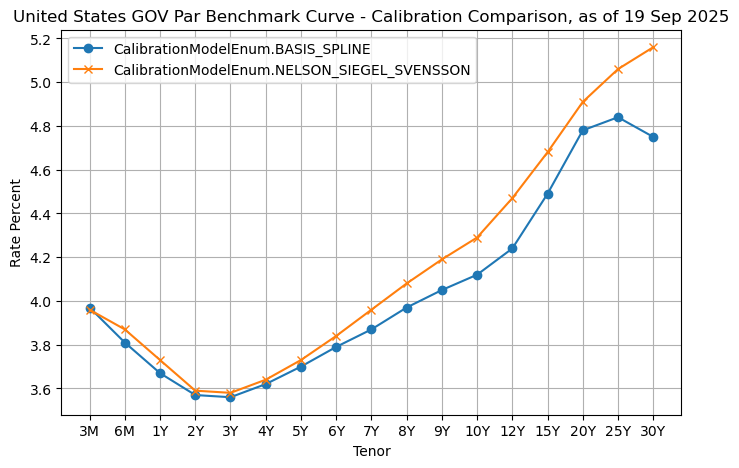

In [8]:
# Display results to compare basis_spline and nelson_siegel_svensson calibration methods

display(joined_df)

valuation_date_str = valuation_date.strftime('%d %b %Y')
plt.figure(figsize=(8,5))
plt.plot(rate_vs_tenor_df_base['Tenor'], rate_vs_tenor_df_base['RatePercent'], marker='o', label=f'{calibration_mode_base}')
plt.plot(rate_vs_tenor_df_compare['Tenor'], rate_vs_tenor_df_compare['RatePercent'], marker='x', label=f'{calibration_mode_compare}')
plt.title(f"{name} - Calibration Comparison, as of {valuation_date_str}")
plt.xlabel('Tenor')
plt.ylabel('Rate Percent')
plt.grid(True)
plt.legend()
plt.show()